In [31]:
import sys
import math
import numpy as np
from scipy import special
from scipy import linalg

In [32]:
class primitive_gaussian():

    def __init__(self, alpha, coeff, coordinates, l1, l2, l3):
        
        self.alpha = alpha
        self.coeff = coeff
        self.coordinates = np.array(coordinates)
        self.A = ( 2.0 * alpha / math.pi ) ** 0.75 # + other terms for l1, l2, l3 > 0


In [33]:
def overlap(molecule):
    
    nbasis = len(molecule)
    
    S = np.zeros([nbasis, nbasis])
    
    for i in range(nbasis):
        for j in range(nbasis):
            
            nprimitives_i = len(molecule[i])
            nprimitives_j = len(molecule[j])
            
            for k in range(nprimitives_i):
                for l in range(nprimitives_j):
                    
                    N = molecule[i][k].A * molecule[j][l].A
                    p = molecule[i][k].alpha + molecule[j][l].alpha
                    q = molecule[i][k].alpha * molecule[j][l].alpha / p
                    Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                    Q2 = np.dot(Q,Q)
                    
                    S[i,j] += N * molecule[i][k].coeff * molecule[j][l].coeff * math.exp(-q*Q2) * (math.pi/p)**(3/2) 
    
    return S
    

In [34]:
def kinetic(molecule):
    
    nbasis = len(molecule)
    
    T = np.zeros([nbasis, nbasis])
    
    for i in range(nbasis):
        for j in range(nbasis):

            nprimitives_i = len(molecule[i])
            nprimitives_j = len(molecule[j])
            
            for k in range(nprimitives_i):
                for l in range(nprimitives_j):

                    N = molecule[i][k].A * molecule[j][l].A
                    cacb = molecule[i][k].coeff * molecule[j][l].coeff
                    
                    p   = molecule[i][k].alpha + molecule[j][l].alpha
                    P   = molecule[i][k].alpha*molecule[i][k].coordinates +  molecule[j][l].alpha*molecule[j][l].coordinates
                    Pp  = P/p
                    PG  = Pp - molecule[j][l].coordinates
                    PGx2 = PG[0]*PG[0]
                    PGy2 = PG[1]*PG[1]
                    PGz2 = PG[2]*PG[2]

                    q = molecule[i][k].alpha * molecule[j][l].alpha / p
                    Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                    Q2 = np.dot(Q,Q)
                
                    s = math.exp(-q*Q2) * (math.pi/p)**(3/2) * N * cacb
                    
                    T[i,j] += 3.0 * molecule[j][l].alpha * s
                    T[i,j] -= 2.0 * molecule[j][l].alpha * molecule[j][l].alpha * s * (PGx2 + 0.5/p)
                    T[i,j] -= 2.0 * molecule[j][l].alpha * molecule[j][l].alpha * s * (PGy2 + 0.5/p)
                    T[i,j] -= 2.0 * molecule[j][l].alpha * molecule[j][l].alpha * s * (PGz2 + 0.5/p)

    return T           
                    
                    

In [35]:
def boys(x,n):
    if x == 0:
        return 1.0/(2*n+1)
    else:
        return special.gammainc(n+0.5,x) * special.gamma(n+0.5) * (1.0/(2*x**(n+0.5)))
    

def electron_nuclear_attraction(molecule, Z):
    
    natoms = len(Z)
    nbasis = len(molecule)   
    
    coordinates = []
    for i in range(nbasis):
        nprimitives_i = len(molecule[i])
        for j in range(nprimitives_i):
            coordinates.append(molecule[i][j].coordinates )

    coordinates = np.array(coordinates)
    coordinates = np.unique(coordinates, axis=0)
    
    V_ne = np.zeros([nbasis, nbasis])
 
    for atom in range(natoms):
        for i in range(nbasis):
            for j in range(nbasis):

                nprimitives_i = len(molecule[i])
                nprimitives_j = len(molecule[j])
            
                for k in range(nprimitives_i):
                    for l in range(nprimitives_j):

                        N = molecule[i][k].A * molecule[j][l].A
                        cacb = molecule[i][k].coeff * molecule[j][l].coeff
                    
                        p   = molecule[i][k].alpha + molecule[j][l].alpha
                        P   = molecule[i][k].alpha*molecule[i][k].coordinates +  molecule[j][l].alpha*molecule[j][l].coordinates
                        Pp  = P/p
                        
                        PG  = P/p - coordinates[atom]
                        
                        PG2 = np.dot(PG,PG)

                        q = molecule[i][k].alpha * molecule[j][l].alpha / p
                        Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                        Q2 = np.dot(Q,Q)
                    
                        V_ne[i,j] +=  N * cacb * -Z[atom] * (2.0*math.pi/p) * math.exp(-q*Q2) * boys(p*PG2,0)                                     
                    

    return V_ne           
                    
                    

In [36]:
def electron_electron_repulsion(molecule):
    
    nbasis = len(molecule)   
    
    V_ee = np.zeros([nbasis, nbasis, nbasis, nbasis])
 
    for i in range(nbasis):
        for j in range(nbasis):
            for k in range(nbasis):
                for l in range(nbasis):

                    nprimitives_i = len(molecule[i])
                    nprimitives_j = len(molecule[j])
                    nprimitives_k = len(molecule[k])
                    nprimitives_l = len(molecule[l])
            
                    for ii in range(nprimitives_i):
                        for jj in range(nprimitives_j):
                            for kk in range(nprimitives_k):
                                for ll in range(nprimitives_l):

                                    N        = molecule[i][ii].A * molecule[j][jj].A * molecule[k][kk].A * molecule[l][ll].A
                                    cicjckcl = molecule[i][ii].coeff * molecule[j][jj].coeff * \
                                               molecule[k][kk].coeff * molecule[l][ll].coeff
                    
                                    pij = molecule[i][ii].alpha + molecule[j][jj].alpha
                                    pkl = molecule[k][kk].alpha + molecule[l][ll].alpha
                         
                                    Pij = molecule[i][ii].alpha*molecule[i][ii].coordinates +\
                                          molecule[j][jj].alpha*molecule[j][jj].coordinates
                                    Pkl = molecule[k][kk].alpha*molecule[k][kk].coordinates +\
                                          molecule[l][ll].alpha*molecule[l][ll].coordinates
                            
                                    Ppij = Pij/pij
                                    Ppkl = Pkl/pkl
                                    
                                    PpijPpkl  = Ppij - Ppkl
                                    PpijPpkl2 = np.dot(PpijPpkl,PpijPpkl)
                                    denom     = 1.0/pij + 1.0/pkl
                            
                                    qij = molecule[i][ii].alpha * molecule[j][jj].alpha / pij
                                    qkl = molecule[k][kk].alpha * molecule[l][ll].alpha / pkl

                                    Qij = molecule[i][ii].coordinates - molecule[j][jj].coordinates
                                    Qkl = molecule[k][kk].coordinates - molecule[l][ll].coordinates
                                    
                                    Q2ij = np.dot(Qij,Qij)
                                    Q2kl = np.dot(Qkl,Qkl)
                                    
                                    term1 = 2.0*math.pi*math.pi/(pij*pkl)
                                    term2 = math.sqrt(  math.pi/(pij+pkl) )
                                    term3 = math.exp(-qij*Q2ij) 
                                    term4 = math.exp(-qkl*Q2kl)
                                                      
                                    V_ee[i,j,k,l] += N * cicjckcl * term1 * term2 * term3 * term4 * boys(PpijPpkl2/denom,0)  # 3 more                               
                    

    return V_ee           


In [37]:
def nuclear_nuclear_repulsion_energy(atom_coords, zlist):
    
    assert (len(atom_coords) == len(zlist))
    natoms = len(zlist)
    E_NN = 0
    for i in range(natoms):
        Zi = zlist[i]
        for j in range(natoms):
            if j > i:
                Zj = zlist[j]
                Rijx = atom_coords[i][0] - atom_coords[j][0]
                Rijy = atom_coords[i][1] - atom_coords[j][1]
                Rijz = atom_coords[i][2] - atom_coords[j][2]
                Rijx_squared = Rijx*Rijx
                Rijy_squared = Rijy*Rijy
                Rijz_squared = Rijz*Rijz             
                Rij = math.sqrt(Rijx_squared + Rijy_squared + Rijz_squared)      
                E_NN += (Zi*Zj)/Rij
                
    return E_NN
    

In [38]:
# # STO-3G basis for 1s orbital on hydrogen
# H1_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, [0,0,0], 0, 0, 0)
# H1_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, [0,0,0], 0, 0, 0)
# H1_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, [0,0,0], 0, 0, 0)

# H2_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, [0,0,1.4], 0, 0, 0)
# H2_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, [0,0,1.4], 0, 0, 0)
# H2_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, [0,0,1.4], 0, 0, 0)

# zlist = [1.0, 1.0]
# atom_coords = [np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 1.4])]

# H1_1s = [H1_pg1a, H1_pg1b, H1_pg1c]
# H2_1s = [H2_pg1a, H2_pg1b, H2_pg1c]

# molecule = [H1_1s, H2_1s]
# print("\n")
# print("overlap matrix of H2 molecule in STO-3G basis\n", overlap(molecule))
# print("\nkinetic energy matrix of H2 molecule in STO-3G basis\n", kinetic(molecule))
# print("\nelectron nuclear attraction matrix of H2 molecule in STO-3G basis\n", electron_nuclear_attraction(molecule,[1.0,1.0]))
# print("\nelectron electron repulsion matrix of H2 molecule in STO-3G basis\n", electron_electron_repulsion(molecule))
# print("\nnuclear nuclear repulsion term of H2 molecule in STO-3G basis\n", nuclear_nuclear_repulsion_energy(atom_coords, zlist))


# 6-31G basis for 1s orbital on hydrogen
# H1_pg1a = primitive_gaussian(0.1873113696E+02, 0.3349460434E-01, [0,0,0], 0, 0, 0)
# H1_pg1b = primitive_gaussian(0.2825394365E+01, 0.2347269535E+00, [0,0,0], 0, 0, 0)
# H1_pg1c = primitive_gaussian(0.6401216923E+00, 0.8137573261E+00, [0,0,0], 0, 0, 0)
# H1_pg2a = primitive_gaussian(0.1612777588E+00, 1.0000000, [0,0,0], 0, 0, 0)
# H2_pg1a = primitive_gaussian(0.1873113696E+02, 0.3349460434E-01, [0,0,1.4], 0, 0, 0)
# H2_pg1b = primitive_gaussian(0.2825394365E+01, 0.2347269535E+00, [0,0,1.4], 0, 0, 0)
# H2_pg1c = primitive_gaussian(0.6401216923E+00, 0.8137573261E+00, [0,0,1.4], 0, 0, 0)
# H2_pg2a = primitive_gaussian(0.1612777588E+00, 1.0000000, [0,0,1.4], 0, 0, 0)

# zlist = [1.0, 1.0]
# atom_coords = [np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 1.4])]

# H1_1s = [H1_pg1a, H1_pg1b, H1_pg1c]
# H1_2s = [H1_pg2a]
# H2_1s = [H2_pg1a, H2_pg1b, H2_pg1c]
# H2_2s = [H2_pg2a]
# molecule = [H1_1s, H1_2s, H2_1s,  H2_2s]
# print("\n")
# print("overlap matrix of H2 molecule in 6-31G basis\n", overlap(molecule))
# print("\nkinetic energy matrix of H2 molecule in 6-31G basis\n", kinetic(molecule))
# print("\nelectron nuclear attraction matrix of H2 molecule in 6-31G basis\n", electron_nuclear_attraction(molecule,[1.0,1.0]))
# print("\nelectron electron repulsion matrix of H2 molecule in 6-31G basis\n", electron_electron_repulsion(molecule))
# print("\nnuclear nuclear repulsion term of H2 molecule in STO-3G basis\n", nuclear_nuclear_repulsion_energy(atom_coords, zlist))


In [39]:
def compute_G(density_matrix, Vee):
    nbasis_functions = density_matrix.shape[0]
    G = np.zeros((nbasis_functions, nbasis_functions))
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            for k in range(nbasis_functions):
                for l in range(nbasis_functions):
                    density = density_matrix[k,l]
                    J = Vee[i,j,k,l]
                    K = Vee[i,l,k,j]
                    G[i,j] += density*(J-0.5*K)
    return G


def compute_density_matrix(mos):
    nbasis_functions = mos.shape[0]
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    # P = occ*CC_dagger
    occupation = 2.0
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            # mo is (natomic_orbtials x nMOs)
            for oo in range(number_occupied_orbitals):
                C = mos[i, oo]
                C_dagger = mos[j, oo]
                density_matrix[i,j] += occupation * C * C_dagger 
    return density_matrix


def compute_electronic_energy_expectation_value(density_matrix, T, Vne, G):
    
    Hcore = T + Vne
    electronic_energy = 0.0
    nbasis_functions = density_matrix.shape[0]
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            electronic_energy += density_matrix[i,j] * (Hcore[i,j] + 0.5*G[i,j])
    return electronic_energy


def scf_cycle(molecular_terms, scf_parameters, molecule):
    
    S, T, Vne, G = molecular_terms
    tolerance, max_scf_steps = scf_parameters
    electronic_energy = 0.0
    nbasis_functions = len(molecule)
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    
    # 1. Enter into the SCF cycles
    for scf_step in range(max_scf_steps):
        
        electronic_energy_old = electronic_energy
        
        # 2. Compute the 2 electron term, and add it to the 1 electron term
        G = compute_G(density_matrix, Vee)
        
        # 3. Form F, make S unit, then get eigenvalues and eigenvectors - transform eigenvectors back (w.o unitS)
        F = T + Vne + G
        # S^{-1/2} S S^{-1/2}
        S_inverse = linalg.inv(S)
        S_inverse_sqrt = linalg.sqrtm(S_inverse)
        # S^{-1/2} F S^{-1/2}
        F_unitS = np.dot(S_inverse_sqrt, np.dot(F, S_inverse_sqrt))
        eigenvalues, eigenvectors = linalg.eigh(F_unitS)
        mos = np.dot(S_inverse_sqrt, eigenvectors)

        # 4. Form new density matrix using MOs
        density_matrix = compute_density_matrix(mos)
        
        # 5. Compute electronic_energy expectation value
        electronic_energy = compute_electronic_energy_expectation_value(density_matrix, T, Vne, G)
        
        # 6. Check convergence
        if abs(electronic_energy-electronic_energy_old) < tolerance:
            return electronic_energy
    
    print("Warning: Convergence not met")
    return electronic_energy

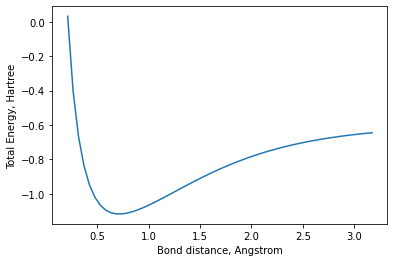

In [40]:
# create many H2 molecules
distances = [round(i*0.1,3) for i in range(4,61)]  # in unit = bohr (a.u of position)
molecule_coordinates = [ [[0.0, 0.0, 0.0], [0.0, 0.0, distance]] for distance in distances]
total_energies = []
for molecule_coordinate in molecule_coordinates:

    # create H2 molecule - sto-3g basis
    H1_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, molecule_coordinate[0], 0, 0, 0)
    H1_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, molecule_coordinate[0], 0, 0, 0)
    H1_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, molecule_coordinate[0], 0, 0, 0)
    H2_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, molecule_coordinate[1], 0, 0, 0)
    H2_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, molecule_coordinate[1], 0, 0, 0)
    H2_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, molecule_coordinate[1], 0, 0, 0)
    number_occupied_orbitals = 1
    zlist = [1.0, 1.0]
    atom_coords = [np.array(molecule_coordinate[0]), np.array(molecule_coordinate[1])]
    H1_1s = [H1_pg1a, H1_pg1b, H1_pg1c]
    H2_1s = [H2_pg1a, H2_pg1b, H2_pg1c]
    molecule = [H1_1s, H2_1s]
    
    # compute scf energy (electronic energy)
    S = overlap(molecule)
    T = kinetic(molecule)
    Vne = electron_nuclear_attraction(molecule, [1.0, 1.0])
    Vee = electron_electron_repulsion(molecule)
    Enn = nuclear_nuclear_repulsion_energy(atom_coords, zlist)
    molecular_terms = [S, T, Vne, Vee]
    scf_parameters = [1e-5, 20]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    # compute total energy - electronic_energy + Enn
    total_energy = electronic_energy + Enn
    total_energies.append(total_energy)
    
# plot bond dissociation curve
import matplotlib.pyplot as plt
plt.xlabel("Bond distance, Angstrom")
plt.ylabel("Total Energy, Hartree")
plt.plot(np.array(distances)*0.529, total_energies)